In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
from itertools import permutations

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

In [18]:
data_path = '../data/corn_not_corn%2.csv'
data = pd.read_csv(data_path, index_col=0)
data['year'] = data['year'].apply(int)
data = data.sort_values(['year', 'county_name', 'commodity_desc'])
data = data.set_index('year')
data = data.drop(columns=['percent'])

# Just get the corn
data = data[data['commodity_desc'] == 'CORN']
data = data.drop(columns=['commodity_desc'])
county_names = data['county_name'].unique()

corn = pd.DataFrame(index=np.arange(1919, 2021))
for county in county_names:
    df = data[data['county_name'] == county]
    corn[county] = df['value']

# corn = corn.interpolate()
corn.head()
corn.size

408

In [3]:
perms = np.array([np.array(p) for p in permutations(np.arange(4))])[:6] # Use for data augmentation

X = corn.to_numpy()
X_max = np.max(X)
X = X/X_max
year = 1919
test_size = 5
window = 10

train_data = [] # Train data starts 1919-1985, predict 1929-1995
test_data = []  # Test data starts 1986-1990, predict 1996-2000
for i in range(len(X) - window):
    X_temp = X.copy()
    for j in range(len(X[0])): # Make a data point for each county that year
        for k, perm in enumerate(perms):
            sample = X_temp[i:i+window]
            sample = sample[:, perm]
            label = X_temp[i+window][0]
            if year+i in np.arange(1986, 1991): # test
                if k == 0:
                    test_data.append([sample, label])
            elif year+i in np.arange(1919, 1986):
                train_data.append([sample, label])
        X_temp = np.roll(X_temp, 1, axis=1)    

batch_size = 24
train_loader = DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=True)
test_loader =  DataLoader(test_data,
                         batch_size=1,
                         shuffle=False)

# plt.plot(np.arange(1919, 2021), X.T[0]*X_max)
# plt.plot(np.arange(1919, 2021), X.T[1]*X_max)
# plt.plot(np.arange(1919, 2021), X.T[2]*X_max)
# plt.plot(np.arange(1919, 2021), X.T[3]*X_max)
# plt.grid()
# plt.show()

In [4]:
class CNN(nn.Module):
    def __init__(self, n_filters=64, kernel_len=3, linear_size=100, dropout=.5):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(kernel_len, 4), padding=(kernel_len//2,0), padding_mode='reflect')
        self.conv2 = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=(kernel_len, 1), padding=(kernel_len//2,0), padding_mode='reflect')
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 1))
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(in_features=n_filters*5, out_features=linear_size)
        self.linear2 = nn.Linear(in_features=linear_size, out_features=1)

    def forward(self, x):
        output = self.relu(self.conv1(x))
        output = self.relu(self.conv2(output))
        output = self.dropout(output)
        output = self.maxpool(output)
        output = self.flatten(output)
        output = self.relu(self.linear1(output))
        return self.linear2(output)

In [8]:
def val_error(model):
    model.eval()
    all_losses = []
    for (x, y_truth) in val_loader:
#         x = x.to(device)
#         y_truth = y_truth.to(device)
        x = x.unsqueeze(1).float()
        y_truth = y_truth.float()

        outputs = model(x)
        outputs = outputs.flatten()
        loss = RMSE(outputs, y_truth)
        all_losses.append(loss.item())
    return np.mean(all_losses)

def RMSE(pred, y_truth):
    MSE = nn.MSELoss()
    return torch.sqrt(MSE(pred, y_truth))


def train_model(n_filters, kernel_len, linear_size, dropout):
    model = CNN(n_filters, kernel_len, linear_size, dropout)
#     model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    num_epochs = 300
    loop = tqdm(total=len(train_loader)*num_epochs, position=0)
    print_every = 5

    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = []
        for (x, y_truth) in train_loader:
            optimizer.zero_grad()

#             x = x.to(device)
#             y_truth = y_truth.to(device)

            x = x.unsqueeze(1).float()
            y_truth = y_truth.float()
            
            outputs = model(x)
            outputs = outputs.flatten()
            loss = RMSE(outputs, y_truth)
            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()

            loop.update()

        if epoch % print_every == 0:
            loop.set_description('epoch:{} loss:{:.5f}'.format(epoch, loss.item()))
        train_losses.append(np.mean(epoch_loss))
#         val_loss = val_error(model)
#         val_losses.append(val_loss)

    plt.plot(train_losses, label='train')
#     plt.plot(val_losses, label='val')
    plt.legend()
    plt.ylim(bottom=0)
    plt.grid()
    plt.title('{}, {}, {}, {}'.format(n_filters, kernel_len, linear_size, dropout))
    plt.show()
#     print('\nFinal Val:', val_losses[-1])
#     return val_losses
    return model

epoch:295 loss:0.01295: 100%|█████████▉| 20096/20100 [01:23<00:00, 242.15it/s]

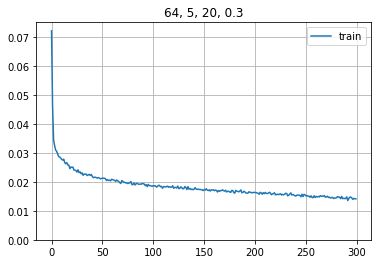

In [9]:
model = train_model(64, 5, 20, 0.3)

In [10]:
model.eval()
test_errors_1year = []
for (x, y_truth) in test_loader:
    x = x.unsqueeze(1).float()
    y_truth = y_truth.float()
    outputs = model(x)
    outputs = outputs.flatten()
    outputs *= X_max   # Reverse normalization
    y_truth *= X_max
    error = RMSE(outputs, y_truth)
    test_errors_1year.append(error.item())
    
print(test_errors_1year)
print(np.mean(test_errors_1year))

[16471.4140625, 4345.51171875, 3251.30859375, 13618.67578125, 18776.859375, 6938.255859375, 8471.3671875, 7381.73828125, 2434.3125, 8360.4921875, 8716.130859375, 16927.41015625, 17067.09375, 10973.986328125, 12264.2890625, 2450.4140625, 77886.5625, 1232.521484375, 3342.5341796875, 58020.23828125]
14946.555810546875


In [12]:
model.eval()

data0 = test_data[0][0]
curr_data = data0.copy()
new_year_data = []
preds = []
for i in range(5):
    for j in range(4):
        x = torch.Tensor(curr_data)
        x = x.unsqueeze(0)
        x = x.unsqueeze(1).float()
        outputs = model(x)
        outputs = outputs.item()
        new_year_data.append(outputs)
        preds.append(outputs)
        curr_data = np.roll(curr_data, 1, axis=1)
    curr_data = np.vstack((curr_data[1:], new_year_data))
    new_year_data = []

preds = np.array(preds) * X_max
labels = np.array([x[1] for x in test_data]) * X_max
test_error_5year = mean_squared_error(labels, preds, squared=False)
print(test_error_5year)

27903.368365377573


epoch:295 loss:0.01295: 100%|██████████| 20100/20100 [01:42<00:00, 242.15it/s]

<AxesSubplot:>

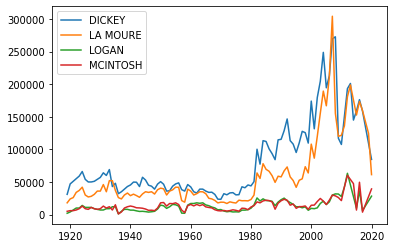

In [96]:
corn.plot()